### IAM Dataset Analysis

Set up the environment and import all the necessary libraries and modules.


In [14]:
from pathlib import Path
from typing import Optional
from enum import Enum

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import xml.etree.ElementTree as ET

from iam import bezier_curves

LINE_STROKES_DATA_DIR = Path("../../datasets/IAM/lineStrokes")
LINE_LABELS_DATA_DIR = Path("../../datasets/IAM/ascii")
LINE_IMAGES_DATA_DIR = Path("../../datasets/IAM/lineImages")

Define the functions used to extract the data from the IAM dataset.


In [15]:
def get_line_from_labels_file(
    labels_file: Path, line_idx: int
) -> Optional[str]:
    """Gets the line label from the labels file.

    Args:
        labels_file (Path): The labels file path.
        line_idx (int): The line index.

    Returns:
        The line label. None if the line label is not found.

    Raises:
        ValueError: If the labels file is invalid.
        FileNotFoundError: If the labels file is not found.
        ValueError: If the labels file is not a file.
        ValueError: If the line label index is not a number.
    """
    # Check if the labels file is valid.
    if not isinstance(labels_file, Path):
        raise ValueError(
            f"Invalid labels file: {labels_file}. Must be an instance of {Path}."
        )

    # Check if the labels file exists.
    if not labels_file.exists():
        raise FileNotFoundError(f"Labels file not found: {labels_file}.")

    # Check if the labels file is a file.
    if not labels_file.is_file():
        raise ValueError(f"Labels file is not a file: {labels_file}.")

    # Check if the line label index is valid.
    if not isinstance(line_idx, int):
        raise ValueError(
            f"Invalid line label index: {line_idx}. Must be an integer."
        )

    # Get the line label from the labels file.
    with open(labels_file, "r", encoding="utf-8") as file:
        # The index of the line where the line labels start (CSR line).
        labels_start_idx = 0

        for i, line in enumerate(file):
            # Check if we have found CSR line and save the index.
            if line.startswith("CSR:"):
                labels_start_idx = i

            if (
                labels_start_idx > 0  # Ensure we have found the CSR line.
                and i
                == labels_start_idx
                + line_idx
                + 1  # Add 1 to skip the blank line after the CSR line.
            ):
                return "".join([char for char in line if char != "\n"])

    # If we have not found the line label, return None.
    return None


def filter_and_get_stroke_file_paths(
    *, root: str, stroke_files: list[str]
) -> list[Path]:
    """Filter the stroke files and return a list of pathlib.Path objects representing the files.

    Args:
        root (str): The root directory of the stroke files.
        stroke_files (list[str]): A list of file names of the stroke files.

    Returns:
        list[Path]: A list of pathlib.Path objects representing the stroke files.
    """
    stroke_file_paths = [
        # Get the full path to the stroke file.
        Path(root) / Path(file)
        for file in stroke_files
        if file.endswith(".xml")
        # Don't include these files. They are invalid or missing data.
        and not file.startswith(
            "z01-000z"
        )  # Exclude files starting with "z01-000z".
        and not file.startswith(
            "a08-551z-08"
        )  # Exclude files starting with "a08-551z-08".
        and not file.startswith(
            "a08-551z-09"
        )  # Exclude files starting with "a08-551z-09".
    ]

    assert all(
        not (
            file.name.startswith("z01-000z")
            and file.name.startswith("a08-551z-08")
            and file.name.startswith("a08-551z-09")
        )
        for file in stroke_file_paths
    ), (
        "Invalid stroke files. "
        'The stroke files must not start with "z01-000z", "a08-551z-08", or "a08-551z-09".'
    )

    return stroke_file_paths


def get_label_from_stroke_file(
    stroke_file: Path,
) -> tuple[Optional[str], str, Path]:
    """Gets the line label and the labels file name that the label belongs to.

    Args:
        stroke_file (Path): The stroke file path.

    Returns:
        The line label, the label file name, and the image file path.
        None if the line label is not found.

    Raises:
        ValueError: If the stroke file is invalid.
        FileNotFoundError: If the stroke file is not found.
        ValueError: If the stroke file is not an XML file.
        ValueError: If the line label index is not a number.
    """
    # Check if the stroke file is valid.
    if not isinstance(stroke_file, Path):
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an instance of {Path}."
        )

    if not stroke_file.is_file():
        raise FileNotFoundError(f"Stroke file not found: {stroke_file}.")

    if stroke_file.suffix != ".xml":
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an XML file."
        )

    # Get the stroke file name without the extension.
    stroke_file_name = stroke_file.stem  # e.g. a01-000u-01

    # Get the line label index.
    line_label_idx_chars = stroke_file_name[-2:]  # e.g. 01
    if not line_label_idx_chars.isdigit():
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. "
            f"Label line index must be a number."
        )
    line_label_idx = int(line_label_idx_chars)

    # Get the labels file directory and name.
    root_labels_dir = stroke_file_name[:3]  # e.g. a01
    sub_labels_dir = stroke_file_name[:7]  # e.g. a01-000
    labels_file_name = stroke_file_name[:-3]  # e.g. a01-000u

    # Get the labels file path. e.g. ../datasets/IAM/ascii/a01/a01-000/a01-000u.txt
    labels_file = (
        LINE_LABELS_DATA_DIR
        / root_labels_dir
        / sub_labels_dir
        / f"{labels_file_name}.txt"
    )

    image_file = (
        LINE_IMAGES_DATA_DIR
        / root_labels_dir
        / sub_labels_dir
        / f"{labels_file_name}-{line_label_idx_chars}.tif"
    )
    assert image_file.exists(), f"Image file not found: {image_file}."

    # Get the line label from the labels file.
    return (
        get_line_from_labels_file(labels_file, line_label_idx),
        labels_file_name,
        image_file,
    )


def parse_stroke_element(stroke_elem: ET.Element) -> bezier_curves.StrokeData:
    """Parses the stroke element.

    Args:
        stroke (ET.Element): The stroke element.

    Returns:
        The stroke data, which contains the x points, y points, time stamps,
        and pen_ups information.

    Raises:
        ValueError: If the stroke element is invalid.
    """
    # Check if the stroke element is valid.
    if not isinstance(stroke_elem, ET.Element):
        raise ValueError(
            f"Invalid stroke ET element: {stroke_elem}. Must be an instance of {ET.Element}."
        )

    x_points = []
    y_points = []
    time_stamps = []
    pen_ups = []
    fst_timestamp = 0

    # Go through each point in the stroke.
    for i, point in enumerate(stroke_elem.findall("Point")):
        x_points.append(float(point.attrib["x"]))
        y_points.append(float(point.attrib["y"]))

        if not time_stamps:
            # Ensure first time stamp is 0, not the actual time stamp.
            fst_timestamp = float(point.attrib["time"])
            time_stamps.append(0)
        else:
            time_stamps.append(float(point.attrib["time"]) - fst_timestamp)

        if i == len(stroke_elem.findall("Point")) - 1:
            # If this is the last point in the stroke, the pen is up.
            pen_ups.append(1)
        else:
            # If this is not the last point in the stroke, the pen is down.
            pen_ups.append(0)

    assert (
        len(x_points) == len(y_points) == len(time_stamps) == len(pen_ups)
    ), (
        f"Invalid stroke element: {stroke_elem}. "
        "The number of x points, y points, time stamps, and pen ups must be equal."
    )

    return bezier_curves.StrokeData(x_points, y_points, time_stamps, pen_ups)


def get_strokes_from_stroke_file(
    stroke_file: Path,
) -> list[bezier_curves.StrokeData]:
    """Gets the list of stroke data from the stroke file.

    Args:
        stroke_file (Path): The stroke file path.

    Returns:
        The list of stroke data.

    Raises:
        ValueError: If the stroke file is invalid.
        FileNotFoundError: If the stroke file is not found.
        ValueError: If the stroke file is not an XML file.
    """
    # Check if the stroke file is valid.
    if not isinstance(stroke_file, Path):
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an instance of {Path}."
        )

    if not stroke_file.is_file():
        raise FileNotFoundError(f"Stroke file not found: {stroke_file}.")

    if stroke_file.suffix != ".xml":
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an XML file."
        )

    tree = ET.parse(stroke_file)
    root = tree.getroot()
    stroke_set = root.find("StrokeSet")

    strokes = [
        parse_stroke_element(stroke) for stroke in stroke_set.findall("Stroke")
    ]

    # Normalize the strokes.
    max_y = float(
        root.find("WhiteboardDescription/DiagonallyOppositeCoords").attrib["y"]
    )

    for stroke in strokes:
        min_x = min(stroke.x_points)
        min_y = min(stroke.y_points)

        # Shift x and y points to start at 0.
        stroke.x_points = [x - min_x for x in stroke.x_points]
        stroke.y_points = [y - min_y for y in stroke.y_points]

        # Scale points so that the y_points are between 0 and 1. The x_points will be scaled
        # by the same amount, to preserve the aspect ratio.
        scale = (
            1 if max_y - min_y == 0 else 1 / (max_y - min_y)
        )  # Avoid division by 0.

        stroke.x_points = [x * scale for x in stroke.x_points]
        stroke.y_points = [y * scale for y in stroke.y_points]

        assert all(0 <= y <= 1 for y in stroke.y_points), (
            f"Invalid stroke file: {stroke_file}. "
            f"All y-points must be between 0 and 1."
        )

    assert all(
        len(stroke.x_points)
        == len(stroke.y_points)
        == len(stroke.time_stamps)
        == len(stroke.pen_ups)
        for stroke in strokes
    ), (
        f"Invalid stroke file: {stroke_file}. "
        "The number of x points, y points, time stamps, and pen ups must be equal."
    )

    return strokes

Extract all data from the IAM dataset.


In [16]:
files = []

for root, _, stroke_files in os.walk(LINE_STROKES_DATA_DIR):
    # Get all stroke files in the directory.
    stroke_files = filter_and_get_stroke_file_paths(
        root=root, stroke_files=stroke_files
    )

    # Go through each stroke file in the directory.
    for stroke_file in stroke_files:
        # Get the label for the stroke file.
        (
            line_label,
            labels_file_name,
            label_image_file,
        ) = get_label_from_stroke_file(stroke_file)

        if line_label is None:
            break

        # Get the strokes from the stroke file.
        strokes = get_strokes_from_stroke_file(stroke_file)
        files.append(
            (
                line_label,
                labels_file_name,
                label_image_file,
                stroke_file,
                len(strokes),
            )
        )

Define the dataset types and a function to set up the data stores for each dataset type.


In [17]:
class DatasetType(Enum):
    """An enum for the dataset types."""

    TRAIN_CROSS_VAL = Path(
        "../../datasets/IAM/trainset.txt"
    )  # Used during cross validation.
    VAL_1 = Path("../../datasets/IAM/valset1.txt")
    VAL_2 = Path("../../datasets/IAM/valset2.txt")
    TEST = Path("../../datasets/IAM/testset.txt")
    TRAIN_SINGLE_VAL = None  # Train and val_1 combined. Used during validation on single dataset.


def set_up_train_val_test_data_stores() -> (
    tuple[
        bezier_curves.BezierData,
        bezier_curves.BezierData,
        bezier_curves.BezierData,
        bezier_curves.BezierData,
    ]
):
    """Set up the data stores for the train, first validation, second validation, and test sets.

    Returns:
        tuple[bezier_curves.BezierData, bezier_curves.BezierData, bezier_curves.BezierData, bezier_curves.BezierData]: A tuple of bezier_curves.BezierData objects for
            the train, first validation, second validation, and test sets.

    Raises:
        ValueError: If the train, first validation, second validation, and test sets are not
            disjoint.
    """

    def get_train_val_test_label_file_names() -> (
        tuple[set[str], set[str], set[str], set[str]]
    ):
        """Get the label file names for train, first validation, second validation, and test sets.

        Returns:
            tuple[set[str], set[str], set[str], set[str]]: A tuple of sets of label file names for
                train, first validation, second validation, and test sets.
        """

        def _get_dataset_label_file_names(
            dataset_type: DatasetType,
        ) -> set[str]:
            """Get the label file names for the given dataset.

            Args:
                dataset_type (DatasetType): The dataset type.

            Returns:
                set[str]: A set of label file names for the given dataset.
            """
            label_file_names = set()
            with open(
                dataset_type.value, "r", encoding="utf-8"
            ) as label_files:
                for label_file_name in label_files:
                    label_file_names.add(label_file_name.strip())
            return label_file_names

        train_cross_val_data_file_names = _get_dataset_label_file_names(
            DatasetType.TRAIN_CROSS_VAL
        )
        val_1_data_file_names = _get_dataset_label_file_names(
            DatasetType.VAL_1
        )
        val_2_data_file_names = _get_dataset_label_file_names(
            DatasetType.VAL_2
        )
        test_data_file_names = _get_dataset_label_file_names(DatasetType.TEST)

        # Check that the train, first validation, second validation, and test sets are disjoint.
        if not train_cross_val_data_file_names.isdisjoint(
            val_1_data_file_names
        ):
            raise ValueError(
                "The train and first validation sets are not disjoint."
            )
        if not train_cross_val_data_file_names.isdisjoint(
            val_2_data_file_names
        ):
            raise ValueError(
                "The train and second validation sets are not disjoint."
            )
        if not train_cross_val_data_file_names.isdisjoint(
            test_data_file_names
        ):
            raise ValueError("The train and test sets are not disjoint.")
        if not val_1_data_file_names.isdisjoint(val_2_data_file_names):
            raise ValueError(
                "The first and second validation sets are not disjoint."
            )
        if not val_1_data_file_names.isdisjoint(test_data_file_names):
            raise ValueError(
                "The first validation and test sets are not disjoint."
            )
        if not val_2_data_file_names.isdisjoint(test_data_file_names):
            raise ValueError(
                "The second validation and test sets are not disjoint."
            )

        return (
            train_cross_val_data_file_names,
            val_1_data_file_names,
            val_2_data_file_names,
            test_data_file_names,
        )

    (
        train_cross_val_label_file_names,
        val_1_label_file_names,
        val_2_label_file_names,
        test_label_file_names,
    ) = get_train_val_test_label_file_names()

    train_cross_val_data = bezier_curves.BezierData(
        label_file_names=train_cross_val_label_file_names
    )  # The train dataset used for cross validation.

    val_1_data = bezier_curves.BezierData(
        label_file_names=val_1_label_file_names
    )  # The first validation dataset.

    val_2_data = bezier_curves.BezierData(
        label_file_names=val_2_label_file_names
    )  # The second validation dataset.

    test_data = bezier_curves.BezierData(
        label_file_names=test_label_file_names
    )  # The test dataset.

    return train_cross_val_data, val_1_data, val_2_data, test_data

Get data files for the train, first validation, second validation, and test sets.


In [18]:
(
    train_cross_val_data,
    val_1_data,
    val_2_data,
    test_data,
) = set_up_train_val_test_data_stores()

train_cross_val_data_files = []
val_1_data_files = []
val_2_data_files = []
test_data_files = []

for i, (_, labels_file_name, _, _, _) in enumerate(files):
    if labels_file_name in train_cross_val_data.label_file_names:
        train_cross_val_data_files.append(files[i])
    elif labels_file_name in val_1_data.label_file_names:
        val_1_data_files.append(files[i])
    elif labels_file_name in val_2_data.label_file_names:
        val_2_data_files.append(files[i])
    elif labels_file_name in test_data.label_file_names:
        test_data_files.append(files[i])

print(
    f"Total files: {len(files)}\n"
    f"Train files: {len(train_cross_val_data_files)}\n"
    f"Val_1 files: {len(val_1_data_files)}\n"
    f"Val_2 files: {len(val_2_data_files)}\n"
    f"Test files: {len(test_data_files)}"
)

Total files: 12185
Train files: 8483
Val_1 files: 1253
Val_2 files: 1214
Test files: 1227


Define a function to display samples from the given files.


In [19]:
def display_samples_from_files(
    num_samples: int, files: list[tuple], title: str
):
    """Display samples from the given files.

    Args:
        num_samples (int): The number of samples to display.
        files (list[tuple]): The list of files to display samples from.
        title (str): The title of the plot.
    """
    # Get a random sample of files.
    random_indices = np.random.choice(
        len(files), size=num_samples, replace=False
    )

    # Calculate the number of rows and columns for the subplots.
    num_rows = math.ceil(num_samples / 2)
    num_cols = 2 if num_samples > 1 else 1

    # Create a grid of subplots.
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 2))

    # If there's only one sample, axs is not a list. Make it a list for consistency.
    if num_samples == 1:
        axs = [axs]

    # Set the title of the plot to be at the top.
    fig.subplots_adjust(top=0.97)
    fig.suptitle(title, fontsize=20)

    # Display the samples.
    for i, idx in enumerate(random_indices):
        (
            line_label,
            _,
            label_image_file,
            _,
            num_strokes,
        ) = files[idx]

        # Display the stroke image.
        axs[i // 2, i % 2].imshow(plt.imread(label_image_file))
        # Set the title of the subplot.
        axs[i // 2, i % 2].set_title(
            f"{line_label} ({num_strokes} strokes)",
        )
        axs[i // 2, i % 2].title.set_fontsize(15)
        # Remove the axis.
        axs[i // 2, i % 2].axis("off")

    # Hide any unused subplots.
    for i in range(num_samples, num_rows * num_cols):
        fig.delaxes(axs.flatten()[i])

    # Adjust the spacing between subplots.
    plt.subplots_adjust(hspace=0.5, wspace=0.1)

    # Display the plot.
    plt.show()

Display samples from the train, val_1, val_2, and test datasets.


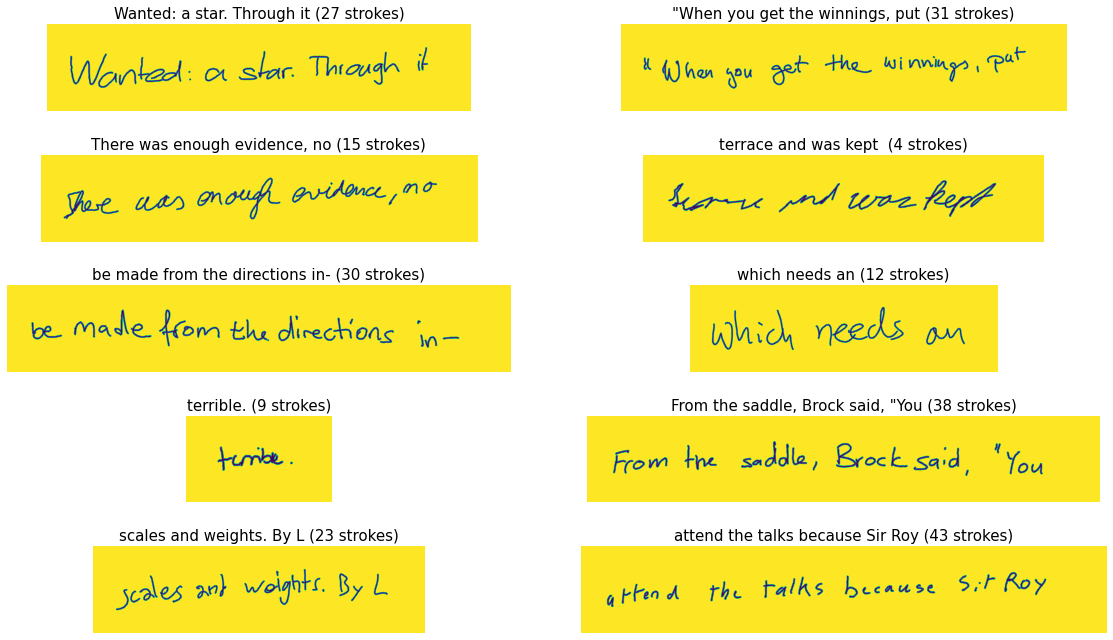

In [24]:
NUM_SAMPLES = 10

display_samples_from_files(
    num_samples=NUM_SAMPLES,
    files=train_cross_val_data_files,
    title="",
)

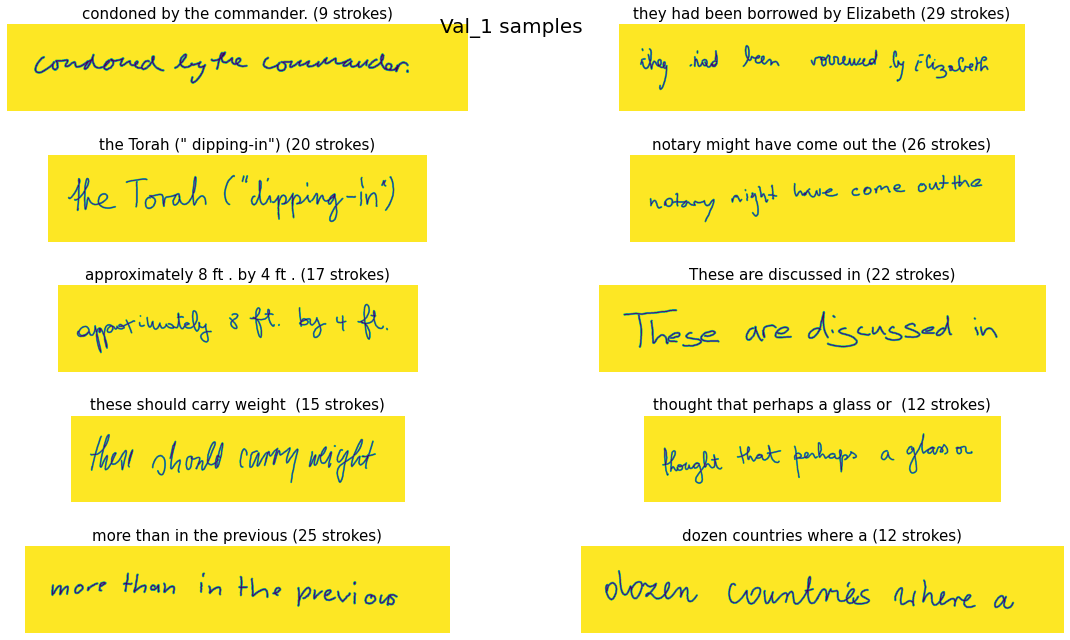

In [21]:
display_samples_from_files(
    num_samples=NUM_SAMPLES,
    files=val_1_data_files,
    title="Val_1 samples",
)

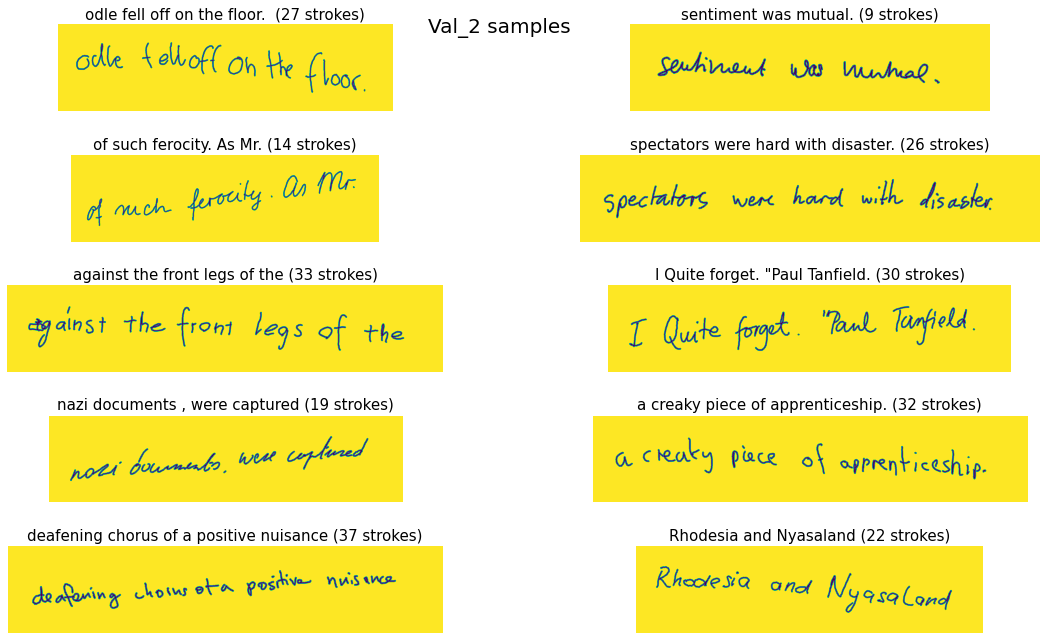

In [22]:
display_samples_from_files(
    num_samples=NUM_SAMPLES,
    files=val_2_data_files,
    title="Val_2 samples",
)

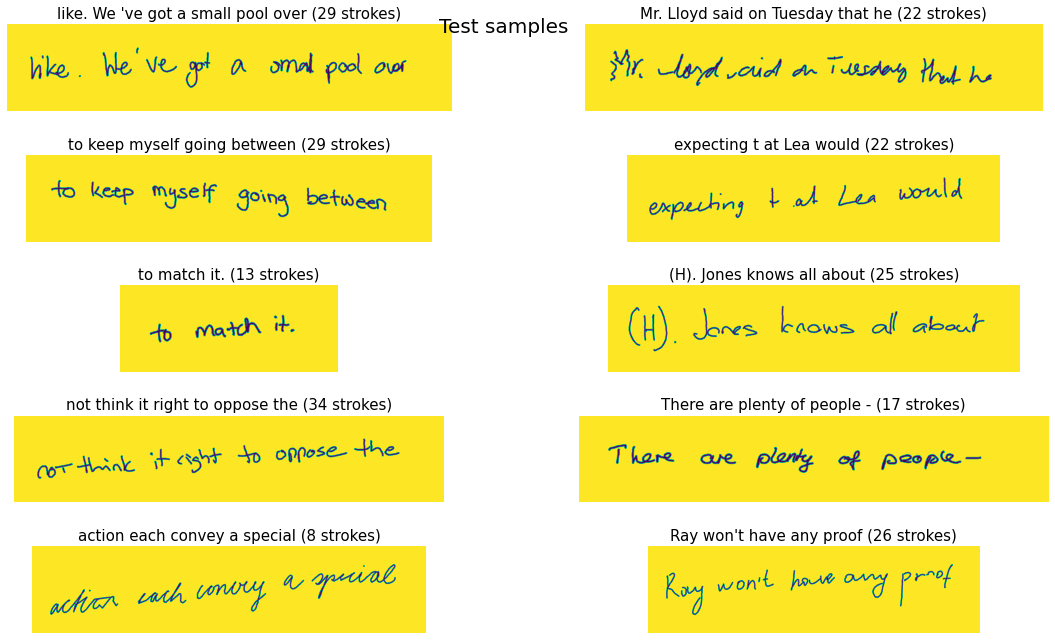

In [23]:
display_samples_from_files(
    num_samples=NUM_SAMPLES,
    files=test_data_files,
    title="Test samples",
)